<h1>Indholdsfortegnelse<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot
import dill

In [2]:
data_path = "../Data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"

In [3]:
File = uproot.open(data_path)
T = File['tree'] 

df = T.pandas.df(entrystop = 10**6)

In [4]:
cols = 'v0_rxy v0_chi2 cosTheta v0_ks_mass'.split(" ")
df = df[cols]

In [5]:
mass = df.v0_ks_mass

In [6]:
from ExternalFunctions import Chi2Regression

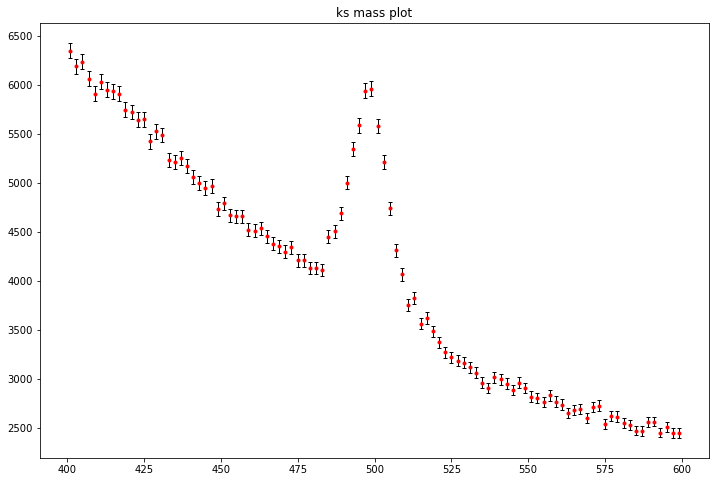

In [7]:
fig, ax = plt.subplots(figsize = (12, 8))

limits = (400, 600)
mass = mass[np.logical_and(mass > limits[0], mass < limits[1])]


bins = 100

vals, edges = np.histogram(mass, bins = bins)
xs = (edges[1:] + edges[:-1])/2

mask = vals > 0
vals = vals[mask]
xs = xs[mask]

errs = np.sqrt(vals)


ax.plot(xs, vals, 'r.')
ax.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
ax.set_title("ks mass plot");

In [8]:
from iminuit import Minuit
from scipy.stats import norm, chi2
from ExternalFunctions import Chi2Regression, nice_string_output, add_text_to_ax
from scipy.optimize import curve_fit


def fit_data(xs, vals, errs, ax = None, guesses_bkgr = [0, 0, -10, 2000], guesses_sig = [498, 6, 17000]):
    if not ax:
        fig, ax = plt.subplots(figsize = (16, 10), ncols = 2)
        ax_sig = ax[1]
        ax_all = ax[0]
        ax_all.plot(xs, vals, 'r.')
        ax_all.errorbar(xs, vals, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')

 
    # The background fit 
#     def background_fit(x, scale, loc, tau):
#         return scale * np.exp(- x / tau)
    
    def background_fit(x, a, b, c, d):
        return a * (x- 498) ** 3 + b * (x-498) ** 2 + c * (x-498) + d
    
    # The signal fit  Here gauss
    def add_signal(x, mean, sig, size):
        return size * norm.pdf(x, mean, sig)
    
    # The full fit
    def full_fit(x, mean, sig, size, a, b, c, d):
        return background_fit(x, a, b, c, d) + add_signal(x, mean, sig, size)
    
    # Background fit under here
    vals_b, cov_b = curve_fit(background_fit, xs, vals, p0 = guesses_bkgr)
    
    b1, b2, b3, b4 = vals_b
    
    bkgr_chi2 = Chi2Regression(background_fit, xs, vals, errs)
    bkgr_min  = Minuit(bkgr_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4)
    
    bkgr_min.migrad()
    
    # Plot result and save guesses
    ax_all.plot(xs, background_fit(xs, *bkgr_min.args),'b--',  label = "background_fit")
    
    b1, b2, b3, b4 = bkgr_min.args
    s1, s2, s3 = guesses_sig
    
    # Full fit
    full_chi2 = Chi2Regression(full_fit, xs, vals, errs)
    full_min  = Minuit(full_chi2, pedantic = False, a = b1, b = b2, c = b3, d = b4, \
                       mean = s1, sig = s2, size = s3)
    
    full_min.migrad()
    
    s1, s2, s3, b1, b2, b3, b4 = full_min.args
    
    ax_all.plot(xs, full_fit(xs, *full_min.args), "k-", label = "full_fit")
    
    ax_all.legend(loc = "upper right")
    
    # Details:
    text = {'chi2': full_min.fval, \
            'pval': chi2.sf(full_min.fval, len(xs) - len(full_min.args)), \
            'mean': f"{full_min.values['mean']:.1f} +/- {full_min.errors['mean']:.1f}",\
            'N':    f"{full_min.values['size']:.1f} +/- {full_min.errors['size']:.1f}"}
    
    text_output = nice_string_output(text)
    add_text_to_ax(0.60, 0.925, text_output, ax_all)
    
    
    # Plot signal seperately
    ax_sig.fill_between(xs, add_signal(xs, s1, s2, s3), color = 'red', alpha = 0.5, label = "sig fit")
    
    vals_sig = vals - background_fit(xs, b1, b2, b3, b4)
    
    ax_sig.plot(xs, vals_sig, 'r.')
    ax_sig.errorbar(xs, vals_sig, errs, color = 'k', elinewidth = 1, capsize = 2, ls = 'none')
    
    sig_amount = np.sum(add_signal(xs, s1, s2, s3))
    bak_amount = np.sum(background_fit(xs, b1, b2, b3, b4))
    
    text_a = {'sig': np.round(sig_amount), \
              'bkgr': np.round(bak_amount), \
              's/b': sig_amount / bak_amount}
    
    text_output = nice_string_output(text_a, decimals = 2)
    add_text_to_ax(0.70, 0.90, text_output, ax_sig)
    
    fig.tight_layout()
    
    bak_func = lambda x: background_fit(x, b1, b2, b3, b4)
    sig_func = lambda x: add_signal(x, s1, s2, s3)
        
    return fig, ax, full_min, bak_func, sig_func, [s1, s2, s3, b1, b2, b3, b4]

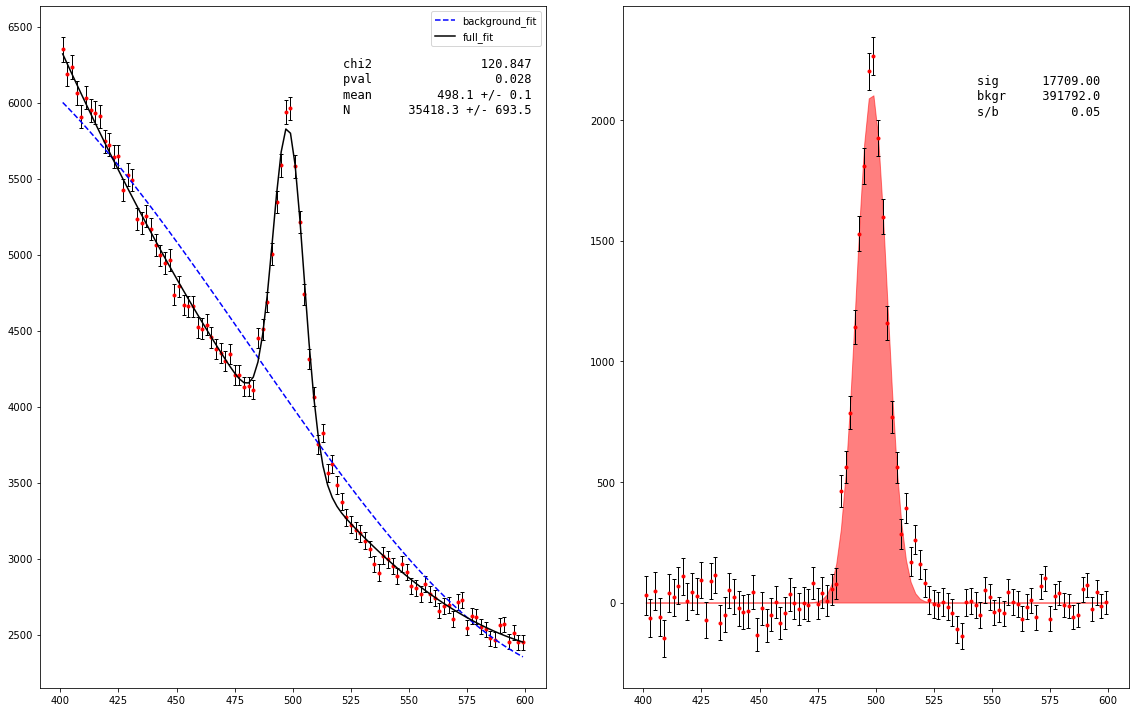

In [9]:
fig, ax, full_min, bk_func, sig_func, varis = fit_data(xs, vals, errs)

In [10]:
full_min.migrad()

------------------------------------------------------------------
| FCN = 120.8                   |     Ncalls=43 (471 total)      |
| EDM = 0.000336 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | mean |  498.13   |   0.13    |            |            |         |         |       |
| 1 | sig  |   6.66    |   0.13    |            |            |         |         |       |
| 2 | size |  0.354E5  |  0.007E5  |            |            |         |         |       |
| 3 | a    |  2.0E-5   |  1.2E-5   |            |            |         |         |       |
| 4 | b    | 0.722E-1  | 0.023E-1  |            |            |         |         |       |
| 5 | c    |  -20.03   |    0.04   |            |            |         |         |       |
| 6 | d    |  0.372E4  |  0.001E4  |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [11]:
# Apply range
mass = mass[(mass > 400) & (mass < 600)]

# Take pseudo_true_sample
mean, sig = varis[0], varis[1]
pseudo_true = mass[abs(mass - mean) <  sig]

am = len(pseudo_true)

# True false
low_false = mass[mass  + 5 * sig < mean].sample(am)
high_false = mass[mass - 5 * sig > mean].sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

DF = df.loc[indicies, :]
DF['label'] = np.zeros(len(DF), dtype = int)
DF.loc[pseudo_true.index, 'label'] = 1


In [12]:
DF

,v0_rxy,v0_chi2,cosTheta,v0_ks_mass,label
entry,,,,,
11,38.141132,0.049485,0.999998,497.202515,1
33,2.426256,4.007922,0.669507,494.344696,1
35,8.187572,0.187095,0.999600,491.615204,1
40,9.154194,1.433040,0.996608,501.108398,1
84,64.163605,0.058721,0.999871,493.411072,1
...,...,...,...,...,...
345182,32.560661,1.080526,-0.968247,547.380310,0
661947,2.638553,3.369466,-0.965239,578.477295,0
628899,5.253850,0.502188,-0.991486,540.377258,0


In [13]:
from xgboost import XGBClassifier

train_cols = ['v0_rxy', 'v0_chi2', 'cosTheta']
DF_train = DF.copy()

scales = []

for col in train_cols:
    DF_train[col] = (DF[col] - DF[col].mean())/DF[col].std()
    scales.append((DF[col].mean(), DF[col].std()))

DF_train = DF_train.loc[:, train_cols]

model = XGBClassifier()
model.fit(DF_train, DF.label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
df = df.loc[(df.v0_ks_mass > 400) & (df.v0_ks_mass < 600), :]

for col, scale in zip(train_cols, scales):
    df[col] = (df[col] - scale[0])/scale[1]

In [15]:
df['xg_label'] = model.predict(df.loc[:, train_cols])

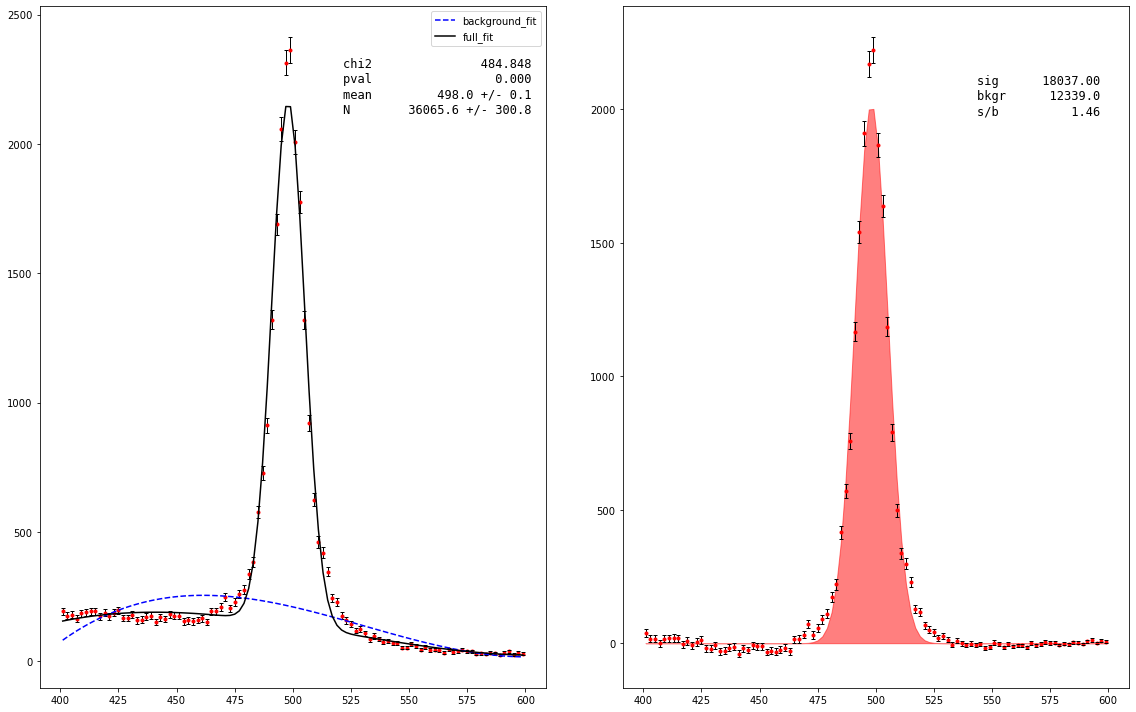

In [16]:
mass_predicted = df.v0_ks_mass[df.xg_label == 1]

bins = 100

vals, edges = np.histogram(mass_predicted, bins = bins)
xs = (edges[1:] + edges[:-1])/2

mask = vals > 0
vals = vals[mask]
xs = xs[mask]

errs = np.sqrt(vals)

fig, ax, full_min, bk_func, sig_func, varis = fit_data(xs, vals, errs)

In [17]:
MC_path = "../Data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
MC_file = uproot.open(MC_path)
T = MC_file['tree']
df_mc = T.pandas.df( 'v0_rxy v0_chi2 cosTheta v0_ks_mass trueKs'.split(" "), entrystop = 10**5)

In [18]:
df_mc = df_mc.loc[(df_mc.v0_ks_mass > 400) & (df_mc.v0_ks_mass < 600), :]

for col, scale in zip(train_cols, scales):
    df_mc[col] = (df_mc[col] - scale[0])/scale[1]

In [19]:
probs = model.predict_proba(df_mc.loc[:, train_cols])

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc_score(df_mc.trueKs, probs[:, 1])

0.9626185692246891

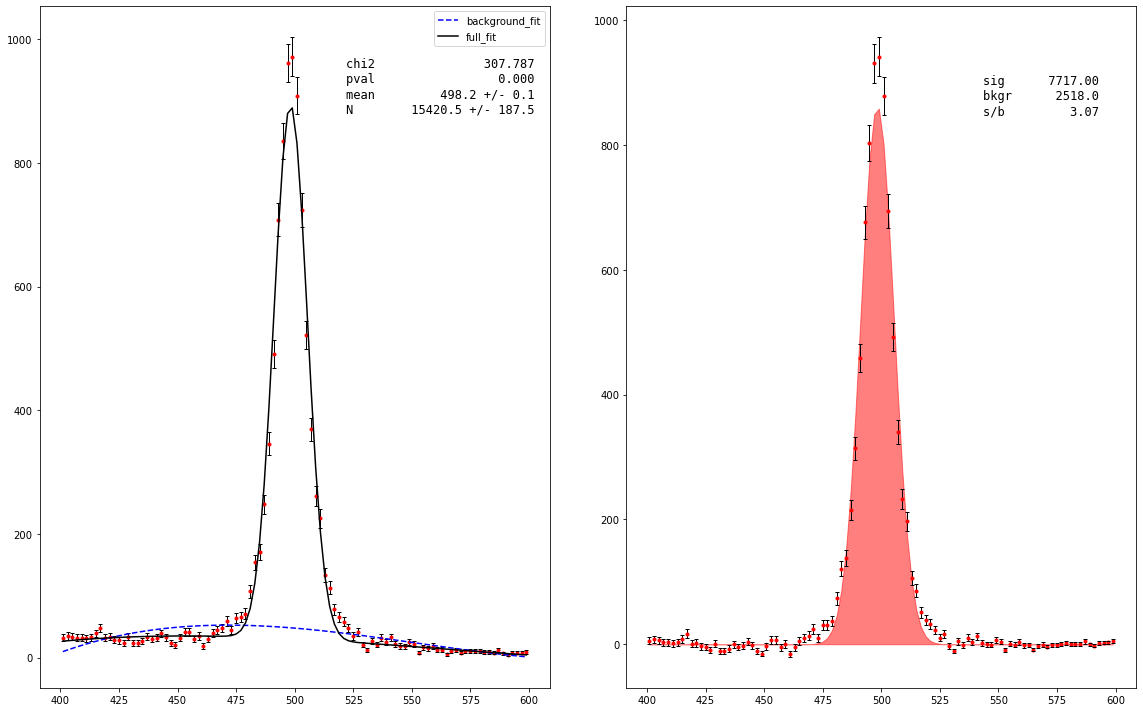

In [21]:
labels = model.predict(df_mc.loc[:, train_cols])

mass_predicted = df_mc.v0_ks_mass[labels == 1]

bins = 100

vals, edges = np.histogram(mass_predicted, bins = bins)
xs = (edges[1:] + edges[:-1])/2

mask = vals > 0
vals = vals[mask]
xs = xs[mask]

errs = np.sqrt(vals)

fig, ax, full_min, bk_func, sig_func, varis = fit_data(xs, vals, errs)

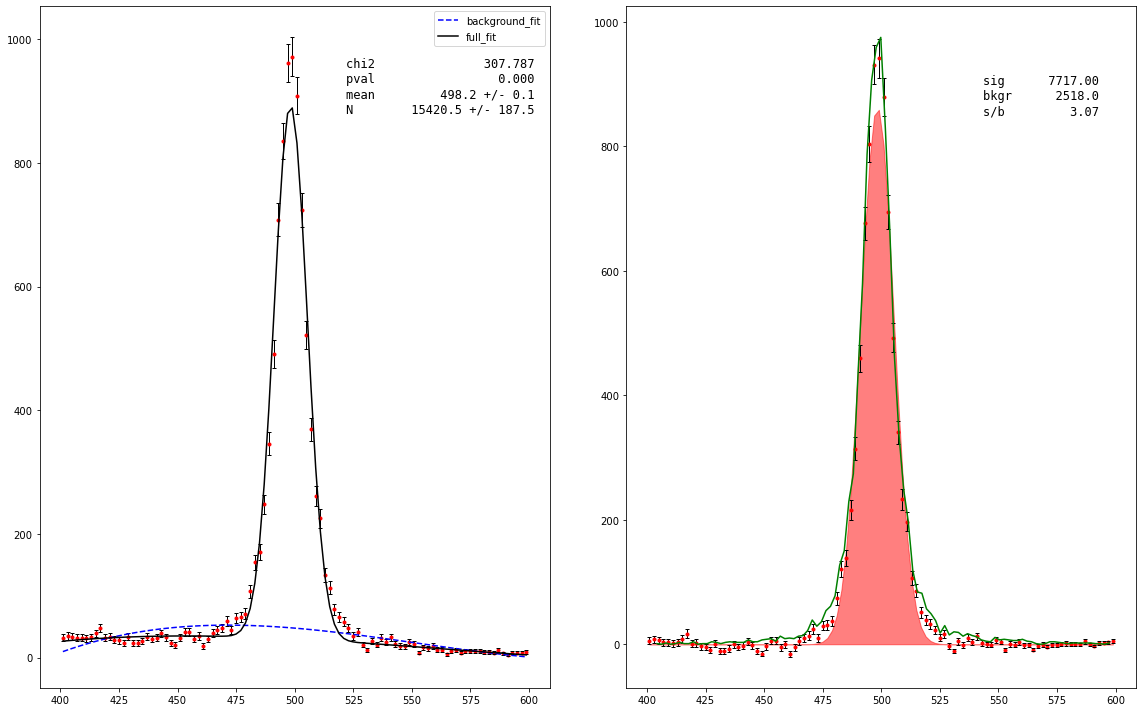

In [22]:
mass_true = df_mc.v0_ks_mass[df_mc.trueKs == 1]

bins = 100

vals_true, edges = np.histogram(mass_true, bins = bins)
xs = (edges[1:] + edges[:-1])/2


ax[1].plot(xs, vals_true, color = "green", label = "True Ks distribution")
fig

In [42]:
def probabilities(df):
    df = df.loc[(df.v0_ks_mass > 400) & (df.v0_ks_mass < 600), :]
    cop = df.copy()
#     print(len(df), len(cop))
    for col, scale in zip(train_cols, scales):
        df[col] = (df[col] - scale[0])/scale[1]
        
    cop['prob'] = model.predict_proba(df.loc[:, train_cols])[:, 1]
    return cop



In [43]:
seri = dill.dumps(probabilities, recurse = True)

file = open("models/data_trained_xg.dat", 'wb')
dill.dump(seri, file)
file.close()

In [41]:
probabilities(df)

,v0_rxy,v0_chi2,cosTheta,v0_ks_mass,xg_label,prob
entry,,,,,,
0,-0.212533,0.873627,-1.088828,486.838989,0,0.899472
1,-0.259665,1.115502,0.913996,415.244232,0,0.872607
3,-0.255216,-0.799577,1.075039,463.033813,0,0.478210
5,-0.257304,2.557638,-0.893781,451.102661,0,0.922207
7,-0.261962,0.385041,-0.198228,523.178711,0,0.766996
...,...,...,...,...,...,...
999988,-0.255473,-0.784952,-1.163171,444.196228,0,0.820510
999993,-0.275292,1.412808,-1.157298,457.704529,0,0.929977
999995,-0.282211,-0.945769,1.082253,430.506042,0,0.478210
